<a href="https://colab.research.google.com/github/YYIPL/ML_Project/blob/main/Projet_miniVQA_YIAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Nov 27 14:43:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Projet :

Vous devez créer un pipeline d'apprentissage automatique, basé sur les réseau de neurones, sur la tâche Visual Question Answering (VQA). Ceci comprend:*
- Creation d'un modèle
- Creation d'un dataloader
- Entraînement selon les splits
- Test sur le split de test
- Ecriture d'un rapport Scientifique

**Creation d'un modèle**

Les images sont de tailles 124x124. Les modèles classiques proposés par pytorch prennent en entrée des images de taille 224x224. <br/>
Nous voulons un modèle qui prennent en entrée les images de tailles 112x112.

Ce modèle encode l'image avec un CNN, et intègre la question dans le pipeline.

**Creation d'un dataloader**
  - sentence embedding (lente forward pass, il est judicieux de calculer cette représentation que une fois sachant que le modèle est pré-entrainé (et fixé).
  - il faut passer d'image 124x124 en 112x112, ceci permet de faire de la data-augmentation (randomresizecrop, randomflip, ...)
  - Le data loader retourne, au moins, la question, l'image et le label

**Entraînement selon les splits**

Il faut créer une procédure d'entrainement et selectionner votre meilleur modèle. Vous aurez surement besoin des methodes torch.save et torch.load pour gérer la sauvegarde de vos modèles.

Pour plus de facilités, vous pouvez directement connecter votre google drive a votre colab.
https://colab.research.google.com/notebooks/io.ipynb

Il y a plein de manières d'améliorer votre entrainement, voici quelques pistes :
  - crop dataloader (image augmentation)
  - dropout
  - Model ensembling
  - Lr scheduler
  - Early stop


 **Pas permis:**<br/>
 - Scale l'image en 224x224 et utiliser un réseau préentrainé


**Ne pas oublier**
- net.train(), net.eval() ne calcule pas les gradients et le dropout

**PS:**
Utiliser adam optimizer comme pour la scéance CNN.

**Test sur le split de test**:
Pour la compétition, il faut reporter la réponse choisie par le modèle (argmax) (cf sample_submission.csv).<br/>
Pour le rapport, il faut reporter l'accuracy top-1 (donnée par le argmax, i.e. cette réponse est elle la bonne réponse) et l'accuracy top-5 (la bonne réponse se trouve-elle dans les 5 plus grandes confiances données par votre modèle? )

**Ecriture d'un rapport Scientifique**

Au minimum, expliquer les points ci-dessus.

**Cela *peut* comprendre**:
- Explorez le jeu de données, donnez des exemples pour quelques classes, la distribution des labels (sous forme de graph ?)
- Quand vous prenez une decision (par exemple, data augementation), montrez visuellement l'effet de cette décision
- Expliquez votre réseau, que sont des convolution et du pooling, mettez des figures, expliquez votre stratégie pour définir la taille des filtres, etc..
- Montrez l'évolution de vos résultats par epoch (sous forme de graph ?), plottez l'accuracy, et la loss. Quelle stratégie d'apprentissage utilisez vous (lr scheduler, early stop, ...)
- Si vous utilisez du dropout, model ensembling, autre technique : explication et effet de cette technique, ...
- **PS: on a surement pas le temps de tout faire ! Concentrez vous sur certains points, et montrez leur impact (qu'il soit négatif ou positif, c'est ca la science...)**

In [2]:
!file=1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX && wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='${file} -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="${file} -O images.zip && rm -rf /tmp/cookies.txt \
&& unzip -qq images.zip && \
git clone https://github.com/jbdel/miniVQA

--2020-11-27 14:43:43--  https://docs.google.com/uc?export=download&confirm=iAbl&id=1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX
Resolving docs.google.com (docs.google.com)... 172.217.7.142, 2607:f8b0:4004:805::200e
Connecting to docs.google.com (docs.google.com)|172.217.7.142|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-74-docs.googleusercontent.com/docs/securesc/hh7922idmi4nu9rgid4n55163gu49vc3/afmh3omgsbejape57o9vo6clsq7f3gti/1606488150000/06540366866019348016/04037086814240517585Z/1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX?e=download [following]
--2020-11-27 14:43:43--  https://doc-14-74-docs.googleusercontent.com/docs/securesc/hh7922idmi4nu9rgid4n55163gu49vc3/afmh3omgsbejape57o9vo6clsq7f3gti/1606488150000/06540366866019348016/04037086814240517585Z/1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX?e=download
Resolving doc-14-74-docs.googleusercontent.com (doc-14-74-docs.googleusercontent.com)... 142.250.73.225, 2607:f8b0:4004:82a::2001
Connecting to doc-14-

In [3]:
!ls && ls -d miniVQA/*

image124  images.zip  miniVQA  sample_data
miniVQA/answer_list.txt      miniVQA/sample_submission.csv  miniVQA/val.csv
miniVQA/image_question.json  miniVQA/test.csv
miniVQA/README.md	     miniVQA/train.csv


## **Overview dataset**

In [4]:
!wc -l miniVQA/*.csv

  6288 miniVQA/sample_submission.csv
  6288 miniVQA/test.csv
 50300 miniVQA/train.csv
  6300 miniVQA/val.csv
 69176 total


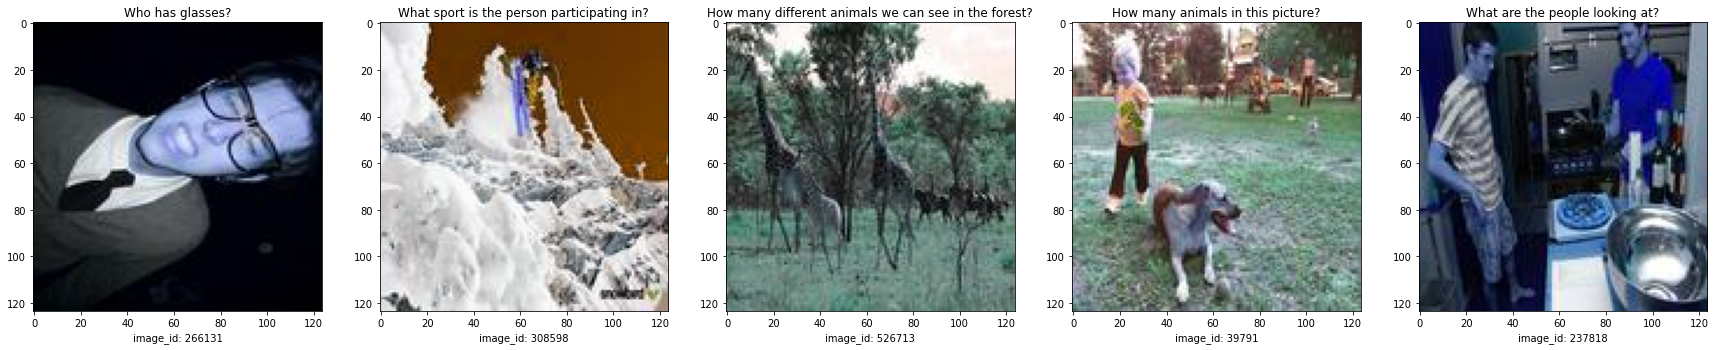

In [5]:
import json
import random
import matplotlib.pyplot as plt
import cv2

image_question = json.load(open('miniVQA/image_question.json'))
plt.figure(figsize=([30, 20]))

for i in range(5):
  plt.subplot(1, 5, i+1)
  random_image = random.choice(list(image_question.keys()))
  _, random_question = random.choice(image_question[random_image])
  plt.imshow(cv2.resize(cv2.imread('image124/'+random_image+'.jpg'), (124,124)))
  plt.xlabel('image_id: '+random_image)
  plt.title(random_question)

## **Sentence Embedding**

In [6]:
!pip install sentence_transformers

     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 1.3MB 21.3MB/s 
     |████████████████████████████████| 2.9MB 51.1MB/s 
     |████████████████████████████████| 890kB 55.5MB/s 
     |████████████████████████████████| 1.1MB 50.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101036 sha256=dcc9c3f80a0fb9c20bf69dd3803e5a100d77b8d448c5242934a8862ff64eaacf
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=8382769a3c3c3e6b6e305ef32192833819aa388420407b7feb79b09091aaed2d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [7]:
from sentence_transformers import SentenceTransformer
import time

model = SentenceTransformer('distilbert-base-nli-mean-tokens').cuda() # ne pas toucher

sentences = 'This framework generates embeddings for each input sentence word hello ok'
time_start = time.time()
sentence_embeddings = model.encode(sentences)
print(time.time()-time_start)
print(sentence_embeddings.shape)


100%|██████████| 245M/245M [00:10<00:00, 23.4MB/s]


0.14472246170043945
(768,)


## **Creation d'un dataloader**

In [8]:
import csv

#Key:id de la question    Value: Image
questionsIdImages = dict()

#Key:id de la question    Value: la question(string)
questionsIdQuestions = dict()

#Key:la question    Value:la question transformée
questionsEmbedded = dict()


for i in image_question.keys():
  for j in image_question[i]:
    questionId = str(j[0])
    image = str(i)
    question = str(j[1])

    questionsIdImages[questionId] = image
    questionsIdQuestions[questionId] = question

    #optimisation pour ne pas encoder une question plusieurs fois
    if question not in questionsEmbedded.keys():
      questionsEmbedded[question] = model.encode(question)



In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [57]:
from torchvision.transforms import *
import torch
from torch.nn import *
import torch.nn as nn

from PIL import Image
import numpy as np
import torch.nn.functional as F

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  #paramètre split pour pouvoir prendre différentes décisions selon le dataset
  #paramètre random pour savoir si il faut générer des images random pour le dataset train, afin de pouvoir faire des graphes sur l'accuracy du train
  def __init__(self, split, random=False):
        assert split in ["train","val","test"]
        self.split = split
        self.image_dir = "image124/"
        file = f"miniVQA/{split}.csv"

        self.images = []
        self.questions = []
        self.questionsId = []
        self.labels = []

        with open(file,encoding='utf-8-sig') as csvfile:
          csv_reader = csv.reader(csvfile)
          next(csv_reader)
          for line in csv_reader:
            # une ligne dans les fichiers csv est composée: id,label
            questionId = line[0]
            question = questionsEmbedded.get(questionsIdQuestions.get(questionId))

            self.images.append(f"{questionsIdImages.get(questionId)}.jpg")
            self.questions.append(question)
            self.questionsId.append(questionId)

            # pas besoin de label pour le jeu de tests
            if split != "test":
              label = line[1]
              self.labels.append(label)

        if split=="train" and random:
          self.transform = Compose([RandomResizedCrop((112, 112)),
                                    RandomHorizontalFlip(),
                                    RandomVerticalFlip(),
                                    ToTensor(),
                                    AddGaussianNoise(0.1, 0.08)
                                    ]) 
        else : 
          self.transform = Compose([Resize((112, 112)), ToTensor()])

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

  def __getitem__(self, index):
        'Generates one sample of data'
    
        img_path = self.image_dir + self.images[index]
        img = Image.open(img_path).convert('RGB')

        img = self.transform(img)

        label = 0

        #Seuls les dataset train et val ont besoin des labels
        if not self.split == "test":
          label = self.labels[index]
          
        label = np.array(label, dtype=np.int64)
        question = np.array(self.questions[index])
        questionId = np.array(self.questionsId[index], dtype=np.int64)
        return img, question, questionId, label

In [58]:
train_dataset = Dataset(split="train",random=True)
train_accuracy_dataset = Dataset(split="train")
val_dataset = Dataset(split="val")
test_dataset = Dataset(split="test")

training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
training_accuracy_generator = torch.utils.data.DataLoader(train_accuracy_dataset, batch_size=64, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

## **Creation d'un modèle**

In [59]:
class Network(nn.Module):
    def __init__(self, num_classes=None):
        super(Network, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4 ,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=192,kernel_size=3,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(in_channels=192,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(9216 + 768, 4096),
            ReLU(inplace=True),
            Linear(in_features=4096, out_features=4096, bias=True),
            ReLU(inplace=True),
            Dropout(p=0.5, inplace=False),
            Linear(in_features=4096, out_features=num_classes, bias=True),
        )

    def forward(self, image: torch.Tensor, question):
        x = self.features(image)
        x = torch.flatten(x,1) 
        x = torch.cat((x, question),dim=1)  
        x = self.classifier(x)
        return x

## **TRAINING**

In [60]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_accuracy_min = np.Inf

    def __call__(self, val_accuracy, model):

        score = val_accuracy 

        #Premier appel, on save le model une première fois et on met à jour le best_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
        # Si l'accuracy n'est pas meilleure
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            # Si après x epochs l'accuracy ne s'améliore pas et dépasse la patience, on met le early stop à true pour arrêter l'entraînement
            # le x est le counter
            if self.counter >= self.patience:
                self.early_stop = True
        # Mise à jour du best_score, save du model et remise à zéro du compteur de non amélioration
        else:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
            self.counter = 0

    def save_checkpoint(self, val_accuracy, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation accuracy increase ({self.val_accuracy_min:.6f} --> {val_accuracy:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_accuracy_min = val_accuracy

In [61]:
def best5accuracy(accuracies, y):
  accuracies = accuracies.data.cpu().numpy()
  y = y.data.cpu().numpy()
  out = []

  for i in range(len(y)):
    label_proba = dict()

    for j in range(len(accuracies[i])):
      label_proba[j] = accuracies[i][j]

    sorted_proba = dict(sorted(label_proba.items(), key=lambda item:-item[1]))
    best5s = list(sorted_proba.keys())[:5]
    if y[i] in best5s:
      out.append(1)
    else:
      out.append(0)
  return out   

In [63]:
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F

def train(net, batch_size=32, learning_rate=1e-3, num_epochs=1):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-2, max_lr=1e-5,step_size_up=10,mode="triangular") #Learning rate scheduler https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
    early_stopping = EarlyStopping(patience=5)
    
    accuracy_train_epoch = []
    accuracy_val_epoch = []
    accuracy_top_5_val_epoch = []
    train_losses_epoch = []
    val_losses_epoch = []
    for i in range(1, num_epochs + 1):  
      start_time = time.time()

      accuracy = []
      losses = []
      # train avec des images random
      net.train() 
      for j, sample in enumerate(training_generator):
        x, question, _, y = sample 
        optimizer.zero_grad()
        out = net(x.cuda(), question.cuda())
        loss = loss_func(out, y.cuda())

        losses.append(loss.item())
        best = np.argmax(out.data.cpu().numpy(), axis=-1)
        accuracy.extend(list(best == y.data.cpu().numpy()))

        loss.backward()
        optimizer.step()
        scheduler.step()
      net.eval() 
      accuracy_train_epoch.append(np.mean(accuracy) * 100)
      train_losses_epoch.append(np.mean(losses))

      # # calcul de l'accuracy sur le train avec des images normales
      # accuracy = []
      # for j,sample in enumerate(training_accuracy_generator):
      #   x, question, _, y = sample
      #   out = net(x.cuda(),question.cuda())
      #   best = np.argmax(out.data.cpu().numpy(), axis=-1)
      #   accuracy.extend(list(best == y.data.cpu().numpy()))
      # accuracy_train_epoch.append(np.mean(accuracy) * 100)


      # calcul de l'accuracy sur le val
      accuracy = []
      accuracy_top_5= []
      losses = []
      for j, sample in enumerate(val_generator):
        x, question, _, y = sample
        out = net(x.cuda(),question.cuda())
        loss = loss_func(out, y.cuda())
        losses.append(loss.item())

        out_soft = F.softmax(out)
        out_top_5 = best5accuracy(out_soft, y)
        accuracy_top_5.extend(out_top_5)

        best = np.argmax(out.data.cpu().numpy(), axis=-1)
        accuracy.extend(list(best == y.data.cpu().numpy()))

      accuracy_top_5_val_epoch.append(np.mean(accuracy_top_5) * 100)
      accuracy_val_epoch.append(np.mean(accuracy) * 100)
      val_losses_epoch.append(np.mean(losses))

      avg_val_accuracy = np.mean(accuracy)
      elapsed_time = time.time() - start_time 
      print('Epoch {}/{} \t  \t val_accuracy={:.4f} \t time={:.2f}s'.format(i, num_epochs, avg_val_accuracy, elapsed_time))

      #Vérification early stopping

      early_stopping(avg_val_accuracy, net)
      
      if early_stopping.early_stop:
          print("Early stopping")
          break

    plt.figure(figsize=(12,8))
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.plot(list(range(1,i + 1)),accuracy_train_epoch, label='train')
    plt.plot(list(range(1,i + 1)),accuracy_val_epoch, label='val')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.plot(list(range(1,i + 1)),accuracy_top_5_val_epoch, label='val_top5')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.plot(list(range(1,i + 1)),train_losses_epoch, label='train loss')
    plt.plot(list(range(1,i + 1)),val_losses_epoch, label='val loss')
    plt.legend()
    plt.show()
    print("done")



In [ ]:
net = Network(100)
net.cuda()
train(net,num_epochs=30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/30 	  	 val_accuracy=0.1949 	 time=95.72s
Epoch 2/30 	  	 val_accuracy=0.2721 	 time=94.35s
Epoch 3/30 	  	 val_accuracy=0.2865 	 time=93.44s
Epoch 4/30 	  	 val_accuracy=0.3135 	 time=94.36s
Epoch 5/30 	  	 val_accuracy=0.3235 	 time=94.13s
Epoch 6/30 	  	 val_accuracy=0.3325 	 time=94.38s
Epoch 7/30 	  	 val_accuracy=0.3356 	 time=92.91s
Epoch 8/30 	  	 val_accuracy=0.3484 	 time=94.42s


## **Test**

In [ ]:
answers = []
questionsId = []

net.load_state_dict(torch.load('checkpoint.pt'))

for j, sample in enumerate(test_generator):
  x, question, questionId, _ = sample 
  questionId = questionId.cpu().numpy()[0]
  out = net(x.cuda(), question.cuda())

  out_numpy = out.data.cpu().numpy()
  answers.append(np.argmax(out_numpy, axis=1))
  questionsId.append(questionId)

with open('test_submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id", "label"])
    for i in range(len(answers)):
      writer.writerow([questionsId[i], answers[i][0]])

## **TODO**

Modifier learning rate scheduler

Optimizer Adam

Modifier les couches du modèle

Dataset est correct